## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

[GeoJson](https://tools.ietf.org/html/rfc7946#section-3.1.7) is a good way to add data on top of an ipyleaflet map.

For other backgrounds than open streets, you can alter the ipyleaflet.py file to point to one of [these map providers](https://leaflet-extras.github.io/leaflet-providers/preview/)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

import sys
sys.path.append('./lib')

from ipyleaflet import *

/Users/toby/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
data_dir = "../../Data/Weather/"
from pickle import load
with open(data_dir+'/PRCP_residuals_PCA.pickle','rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
with open(data_dir+'stations.pkl','rb') as file:
    Stations=load(file)
Stations.head()


['eigen-vecs', 'stations']


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


In [4]:
len(Stations)

85284

In [5]:
import pandas as pd
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

,0,1,2,3
0,0.147112,-0.281674,0.048528,0.158130
1,0.186929,-0.289265,0.092628,0.023367
2,0.027723,-0.216822,0.038040,0.062050
3,0.054058,0.028526,-0.147606,-0.140824
4,0.092121,-0.014545,-0.007064,-0.134271


In [6]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00420738', u'USC00421273', u'USC00420157', u'USC00426170', u'USC00421259']


,0,1,2,3
station,,,,
USC00420738,0.147112,-0.281674,0.048528,0.158130
USC00421273,0.186929,-0.289265,0.092628,0.023367
USC00420157,0.027723,-0.216822,0.038040,0.062050
USC00426170,0.054058,0.028526,-0.147606,-0.140824
USC00421259,0.092121,-0.014545,-0.007064,-0.134271


In [7]:
table=Eig.join(Stations,how='left')

In [8]:
table=table[['name','latitude','longitude','elevation',0,1,2,3]] #,4,5,6,7]]
table.head(4)

,name,latitude,longitude,elevation,0,1,2,3
station,,,,,,,,
USC00420738,BLANDING,37.6131,-109.4847,1838.6,0.147112,-0.281674,0.048528,0.158130
USC00421273,CEDAR CITY STEAM PLT,37.6667,-113.0333,1830.0,0.186929,-0.289265,0.092628,0.023367
USC00420157,ANETH PLT,37.2558,-109.3292,1394.8,0.027723,-0.216822,0.038040,0.062050
USC00426170,NEWCASTLE,37.6667,-113.5500,1569.7,0.054058,0.028526,-0.147606,-0.140824


In [9]:
import pylab as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Map

In [10]:
table['latitude'].max()

38.0

In [11]:
colors
colors=['black','gray','red','red','yellow']

In [12]:
table.columns

Index([u'name', u'latitude', u'longitude', u'elevation', 0, 1, 2, 3], dtype='object')

In [13]:
#min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
min_lat,max_lat,min_long,max_long = box = \
(table['latitude'].min(), table['latitude'].max(), table['longitude'].min(), table['longitude'].max())
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 7

m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly   
m

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

In [14]:
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBSSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
499
+-------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|            coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|              res_2|              res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+-------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|-3975.9681279375172|2226.5193552251358|324.35763807368573|   2145.8|SSSBBSSB| 37.4403|-112.4819|       SNWD|0.3415303260823011| 0.1314942531736086|0.12569642685188925|0.761567673887

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
2,USC00260099,37.3667,-115.1667,-999.9,1,358.254596
37,USC00261358,37.6128,-114.5264,1334.7,4,219.785875


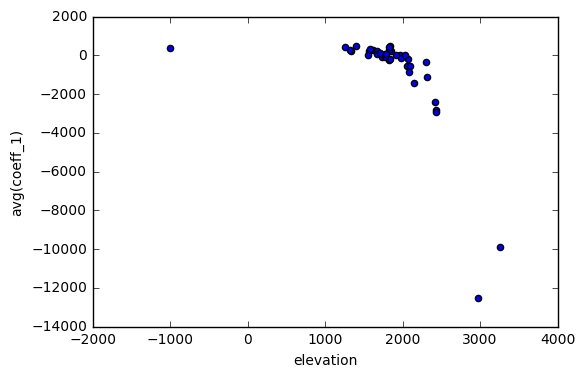

In [16]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');